In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
# plt.rcParams['figure.figsize'] = (10, 7)

# Antenna Layout

### Padding with zeros

Pad the antenna array with zeros to "see" the PSF better. This is equivalent to increasing the length of the time domain signal (say for a top-hat function) to "see" the frequency leakage due to discretized signals.

288 288


<IPython.core.display.Javascript object>


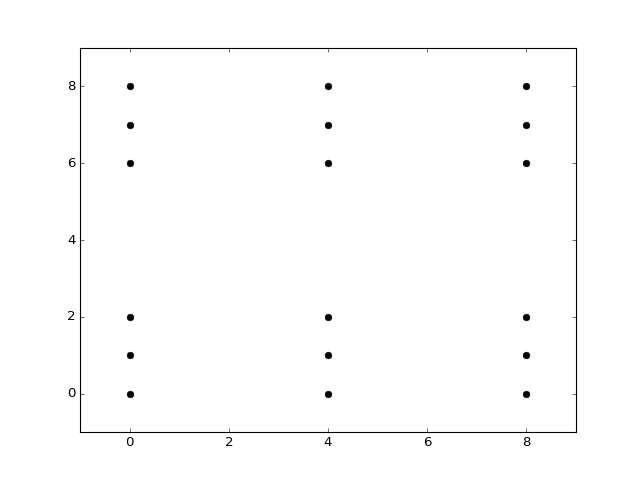

(-1, 9)

In [2]:
ants = np.array([[1,1,1,0,0,0,1,1,1],
                 list(np.zeros(9,dtype=int)),
                 list(np.zeros(9,dtype=int)),
                 list(np.zeros(9,dtype=int)),
                 [1,1,1,0,0,0,1,1,1],
                 list(np.zeros(9,dtype=int)),
                 list(np.zeros(9,dtype=int)),
                 list(np.zeros(9,dtype=int)),
                 [1,1,1,0,0,0,1,1,1]])
ants = np.hstack((ants,np.zeros_like(ants))); ants = np.hstack((ants,np.zeros_like(ants)))
ants = np.hstack((ants,np.zeros_like(ants))); ants = np.hstack((ants,np.zeros_like(ants)))
ants = np.hstack((ants,np.zeros_like(ants)))

ants = np.vstack((ants,np.zeros_like(ants))); ants = np.vstack((ants,np.zeros_like(ants)))
ants = np.vstack((ants,np.zeros_like(ants))); ants = np.vstack((ants,np.zeros_like(ants)))
ants = np.vstack((ants,np.zeros_like(ants)))

ant_x,ant_y = np.shape(ants)
print ant_x,ant_y

fig,ax = plt.subplots(1,1)
for m in range(ant_x):
    for l in range(ant_y):
        if ants[m][l]:
            ax.plot(m,l,'k',marker='o')
ax.set_xlim([-1,9])
ax.set_ylim([-1,9])

# UV plane

The UV-plane is a convolution of the antenna array with itself.

$$\text{UV} = A \star A^*$$

The UV plane is best thought of as the sampling function of the fourier transform of the sky. With an optical telescope you can directly sample real space but with interferometers you can only sample the fourier tranform of the sky.

<IPython.core.display.Javascript object>


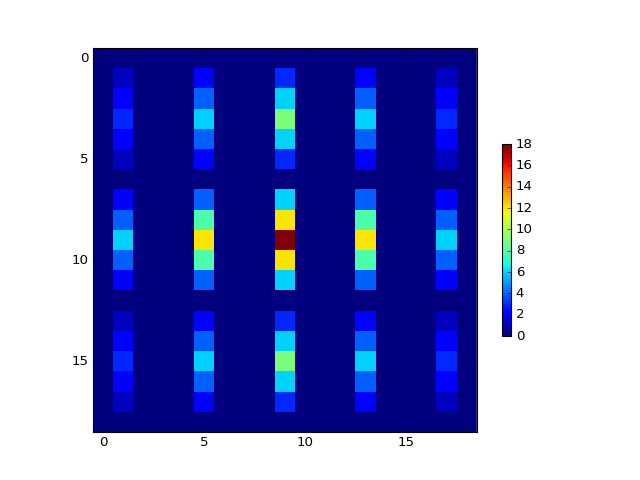

In [3]:
uv_plane = np.fft.fftshift(np.fft.ifft2(np.abs(np.fft.fft2(ants))**2)).T

plt.figure()
plt.imshow(np.abs(uv_plane[18*7+9:18*9-8,18*7+9:18*9-8]),interpolation='none')
plt.colorbar(shrink=0.5)

# Point Spread Function

The PSF of an antenna array is the Fourier transform of the UV plane. This demonstrates what the UV plane translates to on the sky, or gives you the sampling function on the sky.

<IPython.core.display.Javascript object>


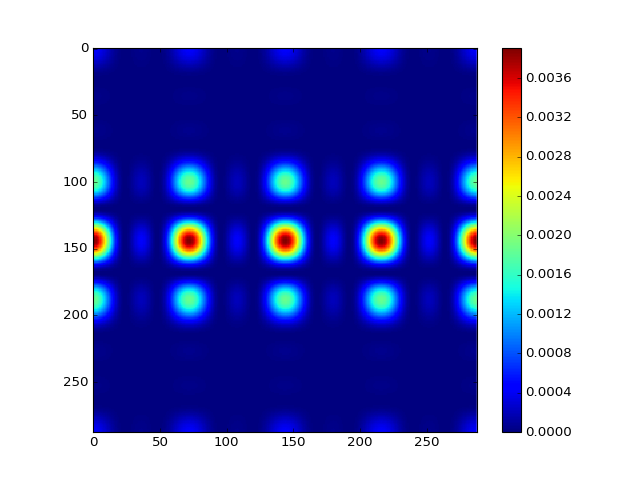

In [4]:
psf = np.fft.ifft2(uv_plane)

plt.figure()
plt.imshow(np.abs(np.fft.fftshift(psf)),interpolation='none')
plt.colorbar()

# Imaging

The PSF of the interferometer convolves with the sky to produce the observed image. Another way to look at it is that the Fourier transform of the UV plane gives the observed image (which then needs to be deconvolved with the PSF to obtain the true sky)

$$ I_O = I_T \star \text{PSF} + N$$

$$ \tilde{I_O} = \tilde{I_T} \times  \text{UV} + N$$

In [5]:
# Baseline separation in cm
bx = 1460; by = 1460 

# Simulate a sky with a point source
thetax = np.pi/4
thetay = np.pi/4

# Wavelength in cm
wv = 3e10/150e6

# Generate antpos
ant_x, ant_y = np.shape(ants)
antpos = {}; ant_num = 0
for i in range(ant_x):
    for j in range(ant_y):
        if ants[i][j]:
            antpos[ant_num] = np.array([i,j,0])
            ant_num += 1

# Gridding the UV Plane

The most computationally intensive process of imaging with radio interferometers is gridding the UV plane. Once you have all the visibilities generated from the array, you need to find the "right" matrix dimensions to Fourier transform. This process of mapping the visibilities onto the UV plane is called gridding. A (u,v) coordinate is defined as:

$$ u = \frac{b_x}{\lambda} \qquad v = \frac{b_y}{\lambda} $$



Below you can see the effect of over-gridding (more sample points than visibilities) and under-gridding (fewer points than visibilities, causing some visibilities to add up). 

**Overgridding** 
1. Higher resolution 
2. More degeneracy (more sidelobes) 

**Undergridding** 
1. Lower resolution
2. Fewer sidelobes.

This effect is exactly the same as changing the distance between the antenna elements (with their diameters, and total number of antennas held constant).

In [6]:
def gen_vis(antpos, source, baseline=(14.6,14.6), freqs=[150e6],res=128):
    
    """Populate the UV plane for a point source at given coordinates
    
    Parameters
    ----------
    antpos  : dict,  keys as antenna numbers and values as array of x,y,z grid points
    source  : tuple, the angle of the source on the sky (theta_x, theta_y)
    baseline: tuple, units of baseline separation between antennas (bx, by)
    freq    : float, frequency at which the observation is being made
    res     : int,   resolution- number of points per side of the UV plane
    
    Results
    -------
    UV      : matrix, populated UV plane matrix
    """
    # Source
    thetax,thetay = source
    
    # Baseline
    bx, by = baseline
    
    # Determine grid of the UV plane
    # Note: For determining the range of UV plane 
    #       do not consider the input baseline.
    grid_pts = np.array(antpos.values())
    Nx = np.max(grid_pts[:,0])*14.6*np.max(freqs)/3e8
    Ny = np.max(grid_pts[:,1])*14.6*np.max(freqs)/3e8
    
    u_bins = np.linspace(-Nx,Nx,num=res)
    v_bins = np.linspace(-Ny,Ny,num=res)

    uv = np.zeros([res,res],dtype=np.complex128)
    
    for f in freqs:
        for ant1,pos1 in antpos.items():
            for ant2,pos2 in antpos.items():
                u = (pos2[0]-pos1[0])*bx*f/3e8
                v = (pos2[1]-pos1[1])*by*f/3e8
                vis = np.exp(2*np.pi*1j*(u*np.sin(thetax)+v*np.sin(thetay)))
                u_pos = np.abs(u_bins - u).argmin()
                v_pos = np.abs(v_bins - v).argmin()
                #print (ant1,ant2,u,v,u_pos,v_pos)
                uv[u_pos,v_pos] += vis
            
    return uv.T

<IPython.core.display.Javascript object>


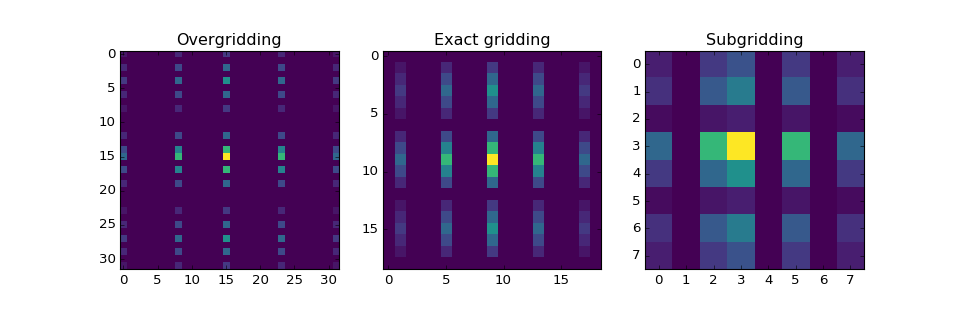

In [8]:
#source = (np.pi/4,np.pi/4)
source = (0,0)
uv = gen_vis(antpos,source,res=32)

uv_sub = gen_vis(antpos, source, res=8)

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.title('Overgridding')
plt.imshow(np.abs(uv),cmap='viridis',interpolation='nearest')
plt.subplot(132)
plt.title('Exact gridding')
plt.imshow(np.abs(uv_plane[18*7+9:18*9-8,18*7+9:18*9-8]),cmap='viridis',interpolation='nearest')
plt.subplot(133)
plt.title('Subgridding')
plt.imshow(np.abs(uv_sub),cmap='viridis',interpolation='nearest')
#plt.colorbar(orientation='horizontal',shrink=0.5)

<IPython.core.display.Javascript object>


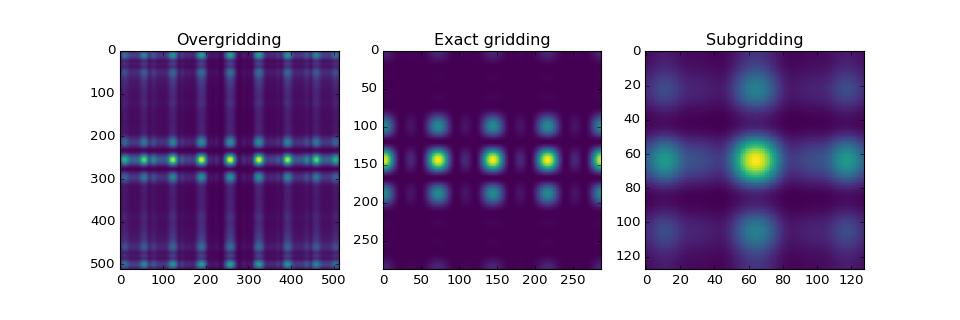

In [9]:
# Pad the UV plane with lots of zeros and fft to get the image

uv = np.hstack((uv,np.zeros_like(uv))); uv = np.hstack((uv,np.zeros_like(uv)))
uv = np.hstack((uv,np.zeros_like(uv))); uv = np.hstack((uv,np.zeros_like(uv)))
uv = np.vstack((uv,np.zeros_like(uv))); uv = np.vstack((uv,np.zeros_like(uv)))
uv = np.vstack((uv,np.zeros_like(uv))); uv = np.vstack((uv,np.zeros_like(uv)))

img = np.fft.fft2(uv)

uv_sub = np.hstack((uv_sub,np.zeros_like(uv_sub))); uv_sub = np.hstack((uv_sub,np.zeros_like(uv_sub)))
uv_sub = np.hstack((uv_sub,np.zeros_like(uv_sub))); uv_sub = np.hstack((uv_sub,np.zeros_like(uv_sub)))
uv_sub = np.vstack((uv_sub,np.zeros_like(uv_sub))); uv_sub = np.vstack((uv_sub,np.zeros_like(uv_sub)))
uv_sub = np.vstack((uv_sub,np.zeros_like(uv_sub))); uv_sub = np.vstack((uv_sub,np.zeros_like(uv_sub)))

img_sub = np.fft.fft2(uv_sub)

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.title('Overgridding')
plt.imshow(np.abs(np.fft.fftshift(img)),cmap='viridis',interpolation='nearest')
plt.subplot(132)
plt.title('Exact gridding')
plt.imshow(np.abs(np.fft.fftshift(psf)),cmap='viridis',interpolation='nearest')
plt.subplot(133)
plt.title('Subgridding')
plt.imshow(np.abs(np.fft.fftshift(img_sub)),cmap='viridis',interpolation='nearest')

# Frequency Synthesis

Multiple frequency channels fall into different UV bins since $(u,v)$ coordinates are a function of frequency.

<IPython.core.display.Javascript object>


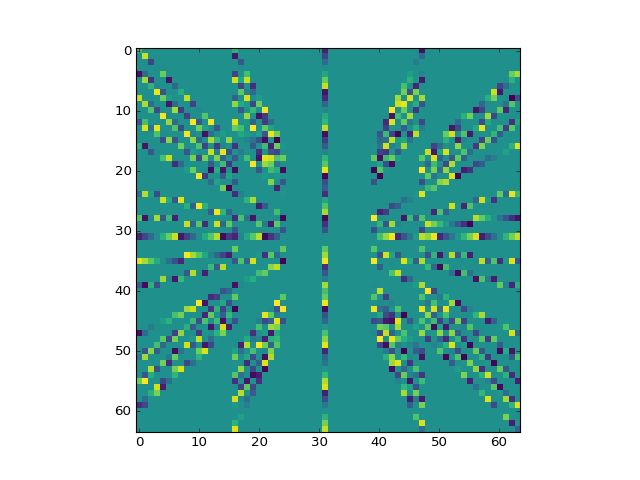

In [14]:
source = (np.pi/3,np.pi/3)
fqs = np.linspace(.1,.2,num=1024)*1e9
uv = gen_vis(antpos,source,freqs=fqs,res=64)

plt.figure()
plt.imshow(np.angle(uv),cmap='viridis',interpolation='nearest')

<IPython.core.display.Javascript object>


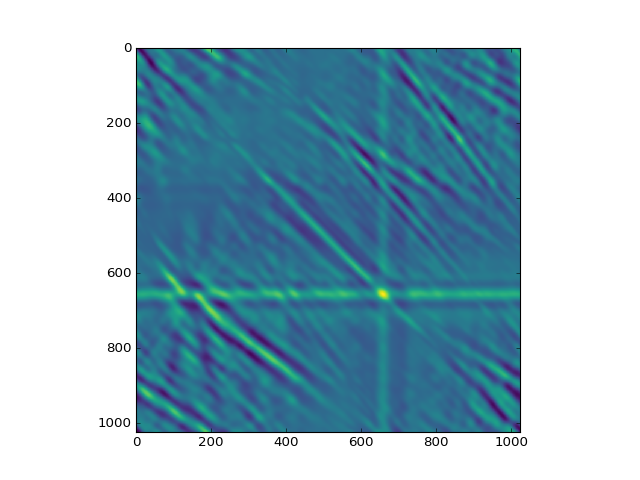

In [15]:
uv = np.hstack((uv,np.zeros_like(uv))); uv = np.hstack((uv,np.zeros_like(uv)))
uv = np.hstack((uv,np.zeros_like(uv))); uv = np.hstack((uv,np.zeros_like(uv)))
uv = np.vstack((uv,np.zeros_like(uv))); uv = np.vstack((uv,np.zeros_like(uv)))
uv = np.vstack((uv,np.zeros_like(uv))); uv = np.vstack((uv,np.zeros_like(uv)))

img = np.fft.fft2(uv)

plt.figure()
plt.imshow(np.abs(np.fft.fftshift(img)),cmap='viridis',interpolation='nearest')

# Rotation Synthesis

All **x-axis** baselines are oriented in **E-W** direction. The length of these baselines changes as the Earth rotates and populates more points in the UV plane.

In [16]:
source = (np.pi/3,np.pi/3)

# 4 hour of integration => Earth rotates by 60deg.
theta_b = np.linspace(0,np.pi/3,num=1024)

pts = 64
uv = np.zeros([pts,pts],dtype=np.complex)
for angle in theta_b:
    uv += gen_vis(antpos,source,baseline=(14.6*np.cos(angle),14.6),res=pts)

<IPython.core.display.Javascript object>


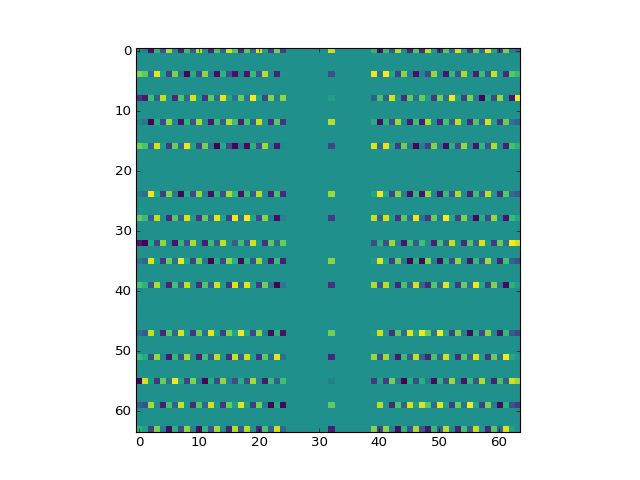

In [17]:
plt.figure()
plt.imshow(np.angle(uv),cmap='viridis',interpolation='nearest')

<IPython.core.display.Javascript object>


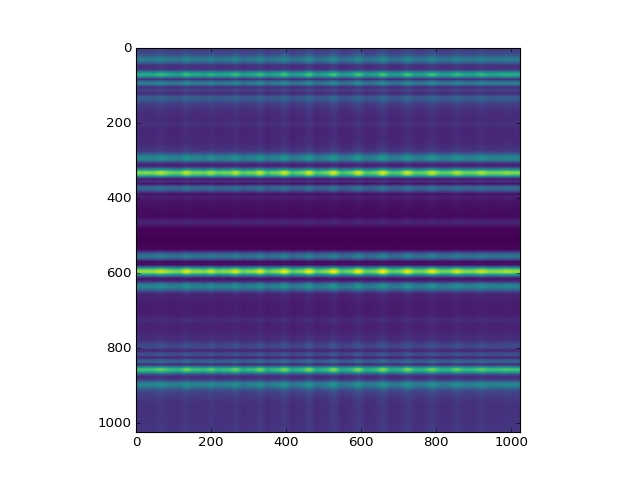

In [18]:
uv = np.hstack((uv,np.zeros_like(uv))); uv = np.hstack((uv,np.zeros_like(uv)))
uv = np.hstack((uv,np.zeros_like(uv))); uv = np.hstack((uv,np.zeros_like(uv)))
uv = np.vstack((uv,np.zeros_like(uv))); uv = np.vstack((uv,np.zeros_like(uv)))
uv = np.vstack((uv,np.zeros_like(uv))); uv = np.vstack((uv,np.zeros_like(uv)))

img = np.fft.fft2(uv)

plt.figure()
plt.imshow(np.abs(np.fft.fftshift(img)),cmap='viridis',interpolation='nearest')

# Both frequency and rotation synthesis

In [21]:
source = (np.pi/3,np.pi/3)

# 4 hour of integration => Earth rotates by 60deg.
theta_b = np.linspace(0,np.pi/3,num=32)

# 100MHz of bandwidth
fqs = np.linspace(.1,.2,num=64)*1e9

pts = 64
uv = np.zeros([pts,pts],dtype=np.complex)
for angle in theta_b:
    uv += gen_vis(antpos,source,baseline=(14.6*np.cos(angle),14.6),freqs=fqs,res=pts)

<IPython.core.display.Javascript object>


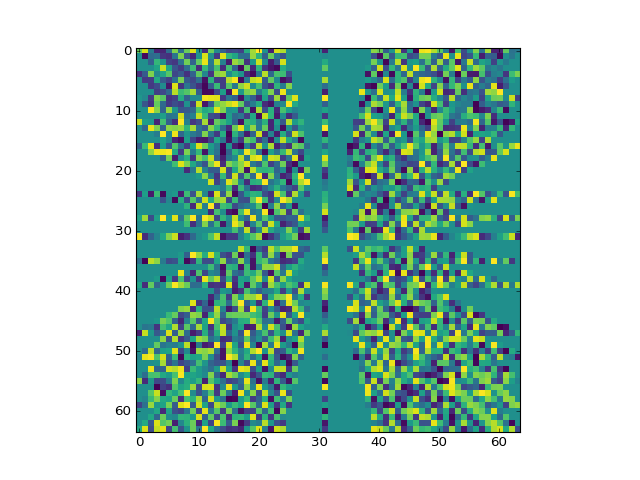

In [22]:
plt.figure()
plt.imshow(np.angle(uv),cmap='viridis',interpolation='nearest')

<IPython.core.display.Javascript object>


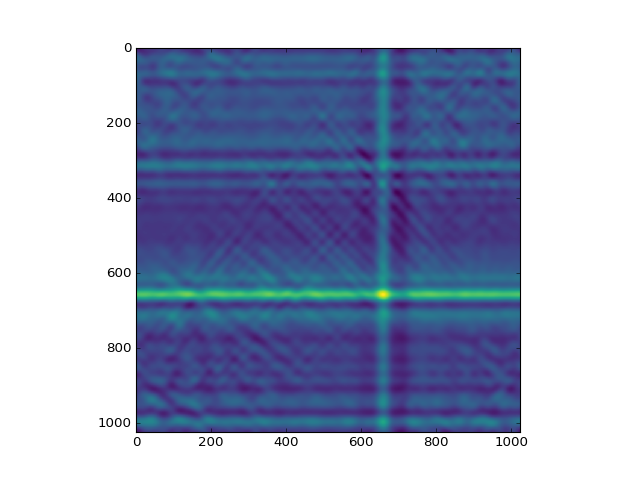

In [23]:
uv = np.hstack((uv,np.zeros_like(uv))); uv = np.hstack((uv,np.zeros_like(uv)))
uv = np.hstack((uv,np.zeros_like(uv))); uv = np.hstack((uv,np.zeros_like(uv)))
uv = np.vstack((uv,np.zeros_like(uv))); uv = np.vstack((uv,np.zeros_like(uv)))
uv = np.vstack((uv,np.zeros_like(uv))); uv = np.vstack((uv,np.zeros_like(uv)))

img = np.fft.fft2(uv)

plt.figure()
plt.imshow(np.abs(np.fft.fftshift(img)),cmap='viridis',interpolation='nearest')